# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [ ]:
# all import statements needed for the project, for example:

import os
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import geopandas as gpd
import math

In [155]:
import requests
from bs4 import BeautifulSoup
import re
import pyarrow.parquet as pq
from sqlalchemy import text
from sqlalchemy import Integer, Float, String, DateTime, Date
from geopandas import GeoDataFrame
from typing import Tuple, Optional
from typing import List
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import numpy as np
from matplotlib.animation import FuncAnimation
import folium
from folium import plugins

In [9]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [10]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [13]:
def load_taxi_zones(shapefile: str) -> GeoDataFrame:
    """
    This function is to load the taxi zone file

    Args:
        shapefile: the file of taxi_zones

    Returns:
        taxi_zones which contain geometry information
    """
    taxi_zones = gpd.read_file(shapefile)
    # Convert to column names to lowercase 
    taxi_zones.columns = [col.lower() for col in taxi_zones.columns]
    taxi_zones = taxi_zones.to_crs(4326)
    # Return the result
    return taxi_zones
    
# Get taxi_zones which will be used when converting ID to longitude and latitude
taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)


In [14]:
def lookup_coords_for_taxi_zone_id(zone_loc_id: int, loaded_taxi_zones: GeoDataFrame) -> Tuple[Optional[float], Optional[float]]:
    """
    Finds the latitude and longitude based on taxi zone ID.
    
    Args:
        zone_loc_id: location ID.
        loaded_taxi_zones: The loaded GeoDataFrame of taxi zones.

    Returns:
        Latitude and longitude of the taxi zone's centroid, or None if not found.
    """
    # Find the zone for the ID
    zone = loaded_taxi_zones[loaded_taxi_zones['locationid'] == zone_loc_id]
    
    if zone.empty:
        # Handle missing location ID
        return (None, None)

    # Re-project geometries to avoid the UserWarning
    projected_zone = zone.to_crs(epsg=2263)
    centroid = projected_zone.geometry.centroid.iloc[0]

    # Convert the centroid back to geographic CRS (EPSG:4326)
    geographic_centroid = gpd.GeoSeries([centroid], crs=projected_zone.crs).to_crs(epsg=4326).iloc[0]

    # Extract latitude and longitude
    latitude, longitude = geographic_centroid.y, geographic_centroid.x

    return latitude, longitude



### Calculate Sample Size

In [16]:
def calculate_sample_size(population: int, confidence_level: float, margin_of_error: float, proportion: float) -> int:
    """
    Calculate the sample size using Cochran's formula.

    Args:
        population: population size
        confidence_level: 90%/95%/99% confidence level can be chosen
        margin_of_error: 1 - confidence_level
        proportion: parameter in the formula(0.5)

    Returns:
        The sample size calculated by Cochran's Formula
    """
    # Common Z-score 
    z_scores = {0.9: 1.645, 0.95: 1.96, 0.99: 2.576}
    if confidence_level not in z_scores:
        raise ValueError("Supported confidence levels are 0.9, 0.95, and 0.99")
    z = z_scores[confidence_level]

    # Based on the formula to calculate n0
    n0 = (z ** 2 * proportion * (1 - proportion)) / (margin_of_error ** 2)

    # calculate sample size
    if population > 0:
        sample_size = n0 / (1 + (n0 - 1) / population)
    else:
        raise ValueError("Population size must be greater than 0")

    # Ensure the sample size is an integer
    return math.ceil(sample_size)


### Common Functions

In [18]:
def get_all_urls_from_tlc_page(taxi_page: str) -> List[str]:
    """
    Fetch all URLs from the given TLC page.

    Args:
        taxi_page: url of page

    Returns:
        all urls
    """
    # Fetch the HTML content from the provided page
    response = requests.get(taxi_page)
    response.raise_for_status()  # Raise HTTPError for bad responses

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all anchor tags with href attributes
    urls = [a['href'] for a in soup.find_all('a', href=True)]
    return urls


### Process Taxi Data

In [20]:
def get_taxi_urls(all_urls):
    """
    From all urls, only find the urls for yellow taxi

    Args:
        all_urls: list of urls

    Returns:
        urls for yellow taxi
    """
    # Pattern which can find url for yellow taxi
    pattern = (
        r'(yellow)_tripdata_('
        r'(2020|2021|2022|2023)-(0[1-9]|1[0-2])|'
        r'2024-(0[1-8])'
        r').parquet$'
    )
    
    # Initialize an empty list
    filtered_urls = []
    # For loop to find and add url for yellow taxi
    for url in all_urls:
        cleaned_url = url.strip()
        if re.search(pattern, cleaned_url):
            filtered_urls.append(cleaned_url)

    return filtered_urls

In [21]:
def get_and_clean_taxi_data(parquet_urls, download_dir="downloaded_parquets", confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    """
    Downloads, samples, and combines yellow taxi data from multiple parquet files.

    Args:
        parquet_urls: List of URLs to parquet files.
        download_dir: Directory to save downloaded parquet files. Default is "downloaded_parquets".
        confidence_level: Confidence level for Cochran's formula (default: 0.95).
        margin_of_error: Margin of error for Cochran's formula (default: 0.05).
        proportion: Estimated proportion for Cochran's formula (default: 0.5).

    Returns:
        A single DataFrame containing combined and cleaned data.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)
    
    # Initialize an empty list
    all_taxi_dataframes = []

    for parquet_url in parquet_urls:
        # Extract file name from the URL
        file_name = os.path.basename(parquet_url)
        local_file_path = os.path.join(download_dir, file_name)

        # Check if the file has already downloaded
        if not os.path.exists(local_file_path):
            print(f"Downloading {file_name}...")
            response = requests.get(parquet_url)
            response.raise_for_status()
            with open(local_file_path, "wb") as file:
                file.write(response.content)
        else:
            print(f"File {file_name} already downloaded.")

        # Load the Parquet file into a DataFrame
        print(f"Processing {file_name}...")
        table = pq.read_table(local_file_path, columns=None, use_threads=True)
        df = table.to_pandas()

        # Calculate sample size 
        population_size = len(df)
        sample_size = calculate_sample_size(population_size, confidence_level, margin_of_error, proportion)
        print(f"Population size: {population_size}, Calculated sample size: {sample_size}")

        # Sample the data
        sampled_df = df.sample(n=min(sample_size, population_size), random_state=42)

        # Only keep columns needed
        sampled_df = clean_yellow_taxi_data(sampled_df)

        # Append the sampled DataFrame to the list
        all_taxi_dataframes.append(sampled_df)

    # Concatenate all DataFrames into a single DataFrame
    taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)

    return taxi_data
    
def clean_yellow_taxi_data(df):
    """
    Cleans the yellow taxi dataset by removing unnecessary columns.

    Args:
        df: Original DataFrame with raw data.

    Returns:
        Cleaned DataFrame with only relevant columns.
    """
    # Columns to keep
    columns_to_keep = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "trip_distance",
        "PULocationID",
        "DOLocationID",
        "fare_amount",
        "total_amount",
        "mta_tax",
        "improvement_surcharge",
        "congestion_surcharge"
    ]

    # Include only relevant columns
    cleaned_df = df[columns_to_keep]

    # Convert to Datetime
    cleaned_df.loc[:, "tpep_pickup_datetime"] = pd.to_datetime(cleaned_df["tpep_pickup_datetime"])
    cleaned_df.loc[:, "tpep_dropoff_datetime"] = pd.to_datetime(cleaned_df["tpep_dropoff_datetime"])


    return cleaned_df


In [22]:
def convert_ids_and_filter_coords(df, taxi_zones):
    """
    Converts pickup and dropoff location IDs to latitude and longitude,
    and removes trips outside the specified latitude/longitude coordinate box.

    Args:
        df: DataFrame containing taxi trip data with location IDs.
        taxi_zones: GeoDataFrame containing taxi zone information.

    Returns:
        Cleaned DataFrame with latitude/longitude and filtered by coordinate box.
    """
    # Convert ID to latitude and longitude using the predefined function
    df["pickup_latitude"], df["pickup_longitude"] = zip(*df["PULocationID"].apply(
        lambda zone_id: lookup_coords_for_taxi_zone_id(zone_id, taxi_zones)
    ))
    df["dropoff_latitude"], df["dropoff_longitude"] = zip(*df["DOLocationID"].apply(
        lambda zone_id: lookup_coords_for_taxi_zone_id(zone_id, taxi_zones)
    ))

    # Remove rows with invalid coordinates
    df = df.dropna(subset=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])

    # Define the coordinate box
    lat_min, lon_min = 40.560445, -74.242330
    lat_max, lon_max = 40.908524, -73.717047

    # Filter trips outside the box
    df = df[
        (df["pickup_latitude"].between(lat_min, lat_max)) &
        (df["pickup_longitude"].between(lon_min, lon_max)) &
        (df["dropoff_latitude"].between(lat_min, lat_max)) &
        (df["dropoff_longitude"].between(lon_min, lon_max))
    ]

    # Drop the original location ID columns
    df = df.drop(columns=["PULocationID", "DOLocationID"])

    return df


In [23]:
def get_taxi_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    taxi_parquet = get_taxi_urls(all_urls)
    taxi_data = get_and_clean_taxi_data(taxi_parquet)
    return taxi_data

In [24]:
taxi_data = get_taxi_data()

File yellow_tripdata_2024-01.parquet already downloaded.
Processing yellow_tripdata_2024-01.parquet...
Population size: 2964624, Calculated sample size: 385
File yellow_tripdata_2024-02.parquet already downloaded.
Processing yellow_tripdata_2024-02.parquet...
Population size: 3007526, Calculated sample size: 385
File yellow_tripdata_2024-03.parquet already downloaded.
Processing yellow_tripdata_2024-03.parquet...
Population size: 3582628, Calculated sample size: 385
File yellow_tripdata_2024-04.parquet already downloaded.
Processing yellow_tripdata_2024-04.parquet...
Population size: 3514289, Calculated sample size: 385
File yellow_tripdata_2024-05.parquet already downloaded.
Processing yellow_tripdata_2024-05.parquet...
Population size: 3723833, Calculated sample size: 385
File yellow_tripdata_2024-06.parquet already downloaded.
Processing yellow_tripdata_2024-06.parquet...
Population size: 3539193, Calculated sample size: 385
File yellow_tripdata_2024-07.parquet already downloaded.
P

In [25]:
# Convert Id to latitude and longitude
taxi_data = convert_ids_and_filter_coords(taxi_data, taxi_zones)

In [26]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,mta_tax,improvement_surcharge,congestion_surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2024-01-20 13:31:30,2024-01-20 14:03:25,17.14,70.0,90.96,0.5,1.0,2.5,40.646985,-73.786530,40.749914,-73.970443
1,2024-01-18 21:52:46,2024-01-18 22:03:21,2.49,13.5,22.50,0.5,1.0,2.5,40.764421,-73.977569,40.790011,-73.945750
2,2024-01-01 03:43:58,2024-01-01 03:50:47,1.84,10.0,12.50,0.5,1.0,0.0,40.866075,-73.919308,40.857779,-73.885867
3,2024-01-19 22:20:12,2024-01-19 22:50:12,3.60,23.3,33.95,0.5,1.0,2.5,40.748497,-73.992438,40.778766,-73.951010
4,2024-01-06 22:41:50,2024-01-06 22:43:24,0.04,3.7,6.20,0.5,1.0,0.0,40.791705,-73.973049,40.791705,-73.973049


In [27]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21182 entries, 0 to 21555
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   21182 non-null  datetime64[us]
 1   tpep_dropoff_datetime  21182 non-null  datetime64[us]
 2   trip_distance          21182 non-null  float64       
 3   fare_amount            21182 non-null  float64       
 4   total_amount           21182 non-null  float64       
 5   mta_tax                21182 non-null  float64       
 6   improvement_surcharge  21182 non-null  float64       
 7   congestion_surcharge   20061 non-null  float64       
 8   pickup_latitude        21182 non-null  float64       
 9   pickup_longitude       21182 non-null  float64       
 10  dropoff_latitude       21182 non-null  float64       
 11  dropoff_longitude      21182 non-null  float64       
dtypes: datetime64[us](2), float64(10)
memory usage: 2.1 MB


In [28]:
taxi_data.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,mta_tax,improvement_surcharge,congestion_surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,21182,21182,21182.000000,21182.000000,21182.000000,21182.000000,21182.000000,20061.000000,21182.000000,21182.000000,21182.000000,21182.000000
mean,2022-05-01 07:36:03.632187,2022-05-01 07:52:06.101690,3.225068,15.235569,22.239370,0.488835,0.542687,2.279049,40.753178,-73.966587,40.755562,-73.970320
min,2009-01-01 01:11:17,2009-01-01 01:11:20,0.000000,-250.000000,-251.000000,-0.500000,-1.000000,-2.500000,40.576961,-74.029893,40.576961,-74.174002
25%,2021-02-28 03:23:30.500000,2021-02-28 03:27:23,1.050000,7.200000,12.600000,0.500000,0.300000,2.500000,40.740337,-73.989845,40.740337,-73.989845
50%,2022-04-30 18:03:17,2022-04-30 18:14:03.500000,1.800000,10.700000,16.800000,0.500000,0.300000,2.500000,40.758028,-73.977698,40.758028,-73.977698
75%,2023-07-01 10:00:46.500000,2023-07-01 10:14:27.750000,3.290000,17.395000,24.500000,0.500000,1.000000,2.500000,40.773633,-73.961764,40.775932,-73.959635
max,2024-08-31 23:00:33,2024-08-31 23:34:12,67.900000,209.500000,262.700000,0.500000,1.000000,2.500000,40.899528,-73.739337,40.899528,-73.726655
std,NaN,NaN,4.105971,14.361014,18.122038,0.096222,0.353219,0.764178,0.032813,0.045560,0.033626,0.037005


### Processing Uber Data

In [30]:
def get_uber_link(all_urls):
    """
    For all urls, only find the urls for Uber

    Args:
        all_urls: all urls in web

    Returns:
        urls for Uber
    """
    # Pattern used to find uber url
    pattern = (
        r'(fhvhv)_tripdata_('
        r'(2020|2021|2022|2023)-(0[1-9]|1[0-2])|'
        r'2024-(0[1-8])'
        r').parquet$'
    )

    filtered_urls = []

    for url in all_urls:
        cleaned_url = url.strip()
        if re.search(pattern, cleaned_url):
            filtered_urls.append(cleaned_url)

    return filtered_urls


In [31]:
def get_and_clean_uber_data(parquet_urls, download_dir="downloaded_uber_parquets", confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    """
    Downloads, samples, and combines Uber trip data from multiple Parquet files.

    Args:
        parquet_urls: List of URLs to Parquet files.
        download_dir: Directory to save downloaded Parquet files.
        confidence_level: Confidence level for Cochran's formula (default: 0.95).
        margin_of_error: Margin of error for Cochran's formula (default: 0.05).
        proportion: Estimated proportion for Cochran's formula (default: 0.5).

    Returns:
        Combined DataFrame containing sampled and cleaned Uber trip data.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)
    
    # Initialize an empty list
    all_uber_dataframes = []

    for parquet_url in parquet_urls:
        # Extract file name from the URL
        file_name = os.path.basename(parquet_url)
        local_file_path = os.path.join(download_dir, file_name)

        # Check if the file has already been downloaded
        if not os.path.exists(local_file_path):
            print(f"Downloading {file_name}...")
            response = requests.get(parquet_url)
            response.raise_for_status()  # Raise an error for a failed request
            with open(local_file_path, "wb") as file:
                file.write(response.content)
        else:
            print(f"File {file_name} already downloaded.")

        # Load the Parquet file into a DataFrame
        print(f"Processing {file_name}...")
        df = pd.read_parquet(local_file_path)

        # Calculate sample size
        population_size = len(df)
        sample_size = calculate_sample_size(population_size, confidence_level, margin_of_error, proportion)
        print(f"Population size: {population_size}, Calculated sample size: {sample_size}")

        # Sample the data
        sampled_df = df.sample(n=min(sample_size, population_size), random_state=42)

        # Clean the Uber data, only keep columns needed
        sampled_df = clean_uber_data(sampled_df)

        # Append the cleaned DataFrame to the list
        all_uber_dataframes.append(sampled_df)

    # Combine all sampled DataFrames into one
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)

    return uber_data

def clean_uber_data(df):
    """
    Cleans the Uber data by retaining only relevant columns.

    Args:
        df: Raw Uber DataFrame.

    Returns:
        Cleaned Uber DataFrame.
    """
    # Columns to keep
    columns_to_keep = [
        "request_datetime",
        "pickup_datetime",
        "PULocationID",
        "DOLocationID",
        "trip_miles",
        "base_passenger_fare",
        "tolls",
        "sales_tax",
        "congestion_surcharge"
    ]

    # Filter DataFrame to retain only necessary columns
    cleaned_df = df[columns_to_keep]

    # Ensure datetime columns are in proper format
    cleaned_df.loc[:, "request_datetime"] = pd.to_datetime(cleaned_df["request_datetime"])
    cleaned_df.loc[:, "pickup_datetime"] = pd.to_datetime(cleaned_df["pickup_datetime"])

    return cleaned_df

In [32]:
def get_uber_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    uber_url = get_uber_link(all_urls)
    uber_data = get_and_clean_uber_data(uber_url)
    uber_data = convert_ids_and_filter_coords(uber_data, taxi_zones)
    return uber_data

In [33]:
uber_data = get_uber_data()

File fhvhv_tripdata_2024-01.parquet already downloaded.
Processing fhvhv_tripdata_2024-01.parquet...
Population size: 19663930, Calculated sample size: 385
File fhvhv_tripdata_2024-02.parquet already downloaded.
Processing fhvhv_tripdata_2024-02.parquet...
Population size: 19359148, Calculated sample size: 385
File fhvhv_tripdata_2024-03.parquet already downloaded.
Processing fhvhv_tripdata_2024-03.parquet...
Population size: 21280788, Calculated sample size: 385
File fhvhv_tripdata_2024-04.parquet already downloaded.
Processing fhvhv_tripdata_2024-04.parquet...
Population size: 19733038, Calculated sample size: 385
File fhvhv_tripdata_2024-05.parquet already downloaded.
Processing fhvhv_tripdata_2024-05.parquet...
Population size: 20704538, Calculated sample size: 385
File fhvhv_tripdata_2024-06.parquet already downloaded.
Processing fhvhv_tripdata_2024-06.parquet...
Population size: 20123226, Calculated sample size: 385
File fhvhv_tripdata_2024-07.parquet already downloaded.
Processi

In [34]:
uber_data.head()

,request_datetime,pickup_datetime,trip_miles,base_passenger_fare,tolls,sales_tax,congestion_surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2024-01-09 21:58:58,2024-01-09 22:11:03,5.466,26.48,5.8,2.87,2.75,40.759818,-73.984197,40.729506,-73.949540
1,2024-01-26 07:58:05,2024-01-26 08:07:17,4.290,27.49,0.0,2.44,0.00,40.646116,-73.951623,40.666559,-73.895364
2,2024-01-19 02:12:56,2024-01-19 02:17:05,2.550,15.14,0.0,1.34,0.00,40.882403,-73.910665,40.857108,-73.932832
3,2024-01-21 01:39:37,2024-01-21 01:44:00,6.370,24.57,0.0,2.18,2.75,40.748575,-73.985156,40.715370,-73.936794
4,2024-01-01 14:14:10,2024-01-01 14:19:17,1.681,12.32,0.0,1.09,0.00,40.744234,-73.906307,40.739495,-73.877118


In [35]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20664 entries, 0 to 21559
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   request_datetime      20664 non-null  datetime64[us]
 1   pickup_datetime       20664 non-null  datetime64[us]
 2   trip_miles            20664 non-null  float64       
 3   base_passenger_fare   20664 non-null  float64       
 4   tolls                 20664 non-null  float64       
 5   sales_tax             20664 non-null  float64       
 6   congestion_surcharge  20664 non-null  float64       
 7   pickup_latitude       20664 non-null  float64       
 8   pickup_longitude      20664 non-null  float64       
 9   dropoff_latitude      20664 non-null  float64       
 10  dropoff_longitude     20664 non-null  float64       
dtypes: datetime64[us](2), float64(9)
memory usage: 1.9 MB


In [36]:
uber_data.describe()

,request_datetime,pickup_datetime,trip_miles,base_passenger_fare,tolls,sales_tax,congestion_surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,20664,20664,20664.000000,20664.000000,20664.000000,20664.000000,20664.000000,20664.000000,20664.000000,20664.000000,20664.000000
mean,2022-04-29 13:18:23.460559,2022-04-29 13:23:19.471593,4.412784,20.940783,0.670038,1.858693,1.059802,40.736533,-73.935109,40.736407,-73.935206
min,2020-01-01 01:08:22,2020-01-01 01:16:05,0.000000,-10.380000,0.000000,0.000000,0.000000,40.561994,-74.170885,40.561994,-74.174002
25%,2021-02-24 08:52:11,2021-02-24 08:57:06,1.560000,10.590000,0.000000,0.910000,0.000000,40.690787,-73.984197,40.690787,-73.984052
50%,2022-04-27 18:46:57,2022-04-27 18:52:01.500000,2.854000,16.610000,0.000000,1.440000,0.000000,40.735035,-73.948788,40.736824,-73.948522
75%,2023-06-28 19:53:44.500000,2023-06-28 19:57:15.750000,5.595250,26.292500,0.000000,2.332500,2.750000,40.774376,-73.900317,40.774376,-73.899735
max,2024-08-31 21:35:47,2024-08-31 21:37:05,44.291000,188.580000,43.970000,17.570000,5.500000,40.899528,-73.726655,40.899528,-73.726655
std,NaN,NaN,4.309254,14.940289,2.621790,1.389093,1.336821,0.067867,0.064576,0.068262,0.068061


### Processing Weather Data

In [38]:
import os
import glob

def get_all_weather_csvs(directory):
    return glob.glob(os.path.join(directory, "*weather.csv"))

notebook_directory = os.getcwd()

csv_files = get_all_weather_csvs(notebook_directory)

print(csv_files)

['C:\\Users\\HH\\4501\\2020_weather.csv', 'C:\\Users\\HH\\4501\\2021_weather.csv', 'C:\\Users\\HH\\4501\\2022_weather.csv', 'C:\\Users\\HH\\4501\\2023_weather.csv', 'C:\\Users\\HH\\4501\\2024_weather.csv']


In [39]:
def clean_month_weather_data_hourly(csv_file):
    """
    clean hourly weather data from a single month's CSV file.
    
    Args:
        csv_file (str): Path to CSV file
        
    Returns:
        pd.DataFrame: Cleaned hourly weather data
    """
    df = pd.read_csv(csv_file)
    
    hourly_columns = [
        'DATE', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
        'HourlyPrecipitation', 'HourlyPresentWeatherType', 
        'HourlyRelativeHumidity', 'HourlyVisibility',
        'HourlyWindDirection', 'HourlyWindSpeed'
    ]
    
    df_hourly = df[hourly_columns].copy()
    
    df_hourly['DATE'] = pd.to_datetime(df_hourly['DATE'])
    
    numeric_columns = [
        'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
        'HourlyPrecipitation', 'HourlyRelativeHumidity',
        'HourlyVisibility', 'HourlyWindDirection', 'HourlyWindSpeed'
    ]
    
    for col in numeric_columns:
        df_hourly[col] = pd.to_numeric(df_hourly[col], errors='coerce')
    
    measurement_columns = numeric_columns.copy()
    df_hourly = df_hourly.dropna(subset=measurement_columns, how='all')
    
    df_hourly.columns = [col.replace('Hourly', '') for col in df_hourly.columns]
    
    return df_hourly

In [40]:
def clean_month_weather_data_daily(csv_file):
    """
    clean daily weather data from a single month's CSV file.
    
    Args:
        csv_file (str): Path to CSV file
        
    Returns:
        pd.DataFrame: Cleaned daily weather data
    """
    df = pd.read_csv(csv_file)
    
    daily_columns = [
        'DATE', 'DailyAverageDewPointTemperature', 
        'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity',
        'DailyAverageWindSpeed', 'DailyPrecipitation', 'DailySnowfall',
        'DailySnowDepth', 'DailyPeakWindSpeed'
    ]
    
    df_daily = df[daily_columns].copy()
    
    df_daily['DATE'] = pd.to_datetime(df_daily['DATE']).dt.date
    
    numeric_columns = [col for col in daily_columns if col != 'DATE']
    
    for col in numeric_columns:
        df_daily[col] = pd.to_numeric(df_daily[col], errors='coerce')
    
    measurement_columns = numeric_columns.copy()
    df_daily = df_daily.dropna(subset=measurement_columns, how='all')
    
    df_daily.columns = [col.replace('Daily', '') for col in df_daily.columns]
    
    return df_daily

In [41]:
def load_and_clean_weather_data():
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [42]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

C:\Users\HH\AppData\Local\Temp\ipykernel_27832\769599857.py:11: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\HH\AppData\Local\Temp\ipykernel_27832\1452503644.py:11: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\HH\AppData\Local\Temp\ipykernel_27832\769599857.py:11: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\HH\AppData\Local\Temp\ipykernel_27832\1452503644.py:11: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\HH\AppData\Local\Temp\ipykernel_27832\769599857.py:11: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory

In [43]:
# Check whether the columns we choosed has mixed type data or not.
print(hourly_weather_data.dtypes)
unique_types = set(type(value) for value in hourly_weather_data["PresentWeatherType"].dropna())
print(f"Unique types in PresentWeatherType: {unique_types}")

DATE                   datetime64[ns]
DewPointTemperature           float64
DryBulbTemperature            float64
Precipitation                 float64
PresentWeatherType             object
RelativeHumidity              float64
Visibility                    float64
WindDirection                 float64
WindSpeed                     float64
dtype: object
Unique types in PresentWeatherType: {<class 'str'>}


In [44]:
hourly_weather_data.head()

,DATE,DewPointTemperature,DryBulbTemperature,Precipitation,PresentWeatherType,RelativeHumidity,Visibility,WindDirection,WindSpeed
0,2020-01-01 00:51:00,26.0,40.0,0.0,NaN,58.0,10.0,NaN,8.0
1,2020-01-01 01:51:00,27.0,39.0,0.0,NaN,61.0,10.0,280.0,8.0
2,2020-01-01 02:51:00,26.0,39.0,0.0,NaN,60.0,10.0,260.0,14.0
3,2020-01-01 03:51:00,24.0,39.0,0.0,NaN,55.0,10.0,250.0,11.0
4,2020-01-01 04:51:00,23.0,38.0,0.0,NaN,55.0,10.0,NaN,6.0


In [45]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54287 entries, 0 to 9406
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 54287 non-null  datetime64[ns]
 1   DewPointTemperature  54194 non-null  float64       
 2   DryBulbTemperature   54240 non-null  float64       
 3   Precipitation        43765 non-null  float64       
 4   PresentWeatherType   14004 non-null  object        
 5   RelativeHumidity     54210 non-null  float64       
 6   Visibility           53833 non-null  float64       
 7   WindDirection        28412 non-null  float64       
 8   WindSpeed            49660 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.1+ MB


In [46]:
hourly_weather_data.describe()

,DATE,DewPointTemperature,DryBulbTemperature,Precipitation,RelativeHumidity,Visibility,WindDirection,WindSpeed
count,54287,54194.000000,54240.000000,43765.000000,54210.000000,53833.000000,28412.000000,49660.000000
mean,2022-05-29 22:45:55.052958976,45.027291,57.245225,0.013187,67.032134,8.275212,105.323807,5.125453
min,2020-01-01 00:51:00,-15.000000,4.000000,0.000000,7.000000,0.000000,0.000000,0.000000
25%,2021-03-18 20:39:30,31.000000,45.000000,0.000000,50.000000,8.000000,0.000000,3.000000
50%,2022-05-28 01:51:00,46.000000,58.000000,0.000000,68.000000,10.000000,50.000000,5.000000
75%,2023-08-15 07:50:00,60.000000,71.000000,0.000000,87.000000,10.000000,240.000000,7.000000
max,2024-10-22 18:51:00,80.000000,97.000000,3.470000,100.000000,10.000000,360.000000,2237.000000
std,NaN,18.223468,16.006419,0.063137,20.711620,2.963262,119.477604,14.653212


In [47]:
print(daily_weather_data.dtypes)

DATE                           object
AverageDewPointTemperature    float64
AverageDryBulbTemperature     float64
AverageRelativeHumidity       float64
AverageWindSpeed              float64
Precipitation                 float64
Snowfall                      float64
SnowDepth                     float64
PeakWindSpeed                 float64
dtype: object


In [48]:
daily_weather_data.head()

,DATE,AverageDewPointTemperature,AverageDryBulbTemperature,AverageRelativeHumidity,AverageWindSpeed,Precipitation,Snowfall,SnowDepth,PeakWindSpeed
24,2020-01-01,21.0,38.0,52.0,8.6,0.00,0.0,0.0,29.0
49,2020-01-02,25.0,41.0,52.0,5.4,0.00,0.0,0.0,22.0
86,2020-01-03,41.0,47.0,82.0,3.4,0.15,0.0,0.0,15.0
144,2020-01-04,45.0,46.0,90.0,4.4,0.27,0.0,0.0,24.0
169,2020-01-05,20.0,39.0,48.0,11.3,NaN,0.0,0.0,43.0


In [49]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1755 entries, 24 to 9387
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        1755 non-null   object 
 1   AverageDewPointTemperature  1632 non-null   float64
 2   AverageDryBulbTemperature   1755 non-null   float64
 3   AverageRelativeHumidity     1636 non-null   float64
 4   AverageWindSpeed            1697 non-null   float64
 5   Precipitation               1566 non-null   float64
 6   Snowfall                    1690 non-null   float64
 7   SnowDepth                   1740 non-null   float64
 8   PeakWindSpeed               1745 non-null   float64
dtypes: float64(8), object(1)
memory usage: 137.1+ KB


In [50]:
daily_weather_data.describe()

,AverageDewPointTemperature,AverageDryBulbTemperature,AverageRelativeHumidity,AverageWindSpeed,Precipitation,Snowfall,SnowDepth,PeakWindSpeed
count,1632.000000,1755.000000,1636.000000,1697.000000,1566.000000,1690.000000,1740.000000,1745.000000
mean,42.547794,58.009117,61.016504,5.000766,0.159100,0.040592,0.155747,93.561032
std,18.201816,16.083056,15.683033,2.339258,0.435775,0.502802,1.045484,390.467399
min,-7.000000,11.000000,19.000000,0.600000,0.000000,0.000000,0.000000,9.000000
25%,28.000000,45.000000,49.000000,3.200000,0.000000,0.000000,0.000000,17.000000
50%,43.000000,59.000000,61.000000,4.600000,0.000000,0.000000,0.000000,22.000000
75%,58.000000,72.000000,72.000000,6.300000,0.100000,0.000000,0.000000,27.000000
max,74.000000,88.000000,95.000000,14.200000,7.130000,14.800000,14.000000,2237.000000


## Part 2: Storing Cleaned Data

In [52]:
engine = db.create_engine(DATABASE_URL)

In [53]:
daily_weather_data.columns

Index(['DATE', 'AverageDewPointTemperature', 'AverageDryBulbTemperature',
       'AverageRelativeHumidity', 'AverageWindSpeed', 'Precipitation',
       'Snowfall', 'SnowDepth', 'PeakWindSpeed'],
      dtype='object')

In [54]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    weather_id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATETIME UNIQUE, -- DATE column
    DewPointTemperature FLOAT,
    DryBulbTemperature FLOAT,
    Precipitation FLOAT,
    PresentWeatherType TEXT,
    RelativeHumidity FLOAT,
    Visibility FLOAT,
    WindDirection FLOAT,
    WindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    weather_id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE UNIQUE, -- DATE column
    AverageDewPointTemperature FLOAT,
    AverageDryBulbTemperature FLOAT,
    AverageRelativeHumidity FLOAT,
    AverageWindSpeed FLOAT,
    Precipitation FLOAT,
    Snowfall FLOAT,
    SnowDepth FLOAT,
    PeakWindSpeed FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    trip_id INTEGER PRIMARY KEY AUTOINCREMENT,
    tpep_pickup_datetime DATETIME,
    tpep_dropoff_datetime DATETIME,
    trip_distance FLOAT,
    fare_amount FLOAT,
    total_amount FLOAT,
    mta_tax FLOAT,
    improvement_surcharge FLOAT,
    congestion_surcharge FLOAT,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    trip_id INTEGER PRIMARY KEY AUTOINCREMENT,
    request_datetime DATETIME,
    pickup_datetime DATETIME,
    trip_miles FLOAT,
    base_passenger_fare FLOAT,
    tolls FLOAT,
    sales_tax FLOAT,
    congestion_surcharge FLOAT,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT
);
"""

In [55]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [56]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(text(HOURLY_WEATHER_SCHEMA))
    connection.execute(text(DAILY_WEATHER_SCHEMA))
    connection.execute(text(TAXI_TRIPS_SCHEMA))
    connection.execute(text(UBER_TRIPS_SCHEMA))


### Add Data to Database

In [58]:
def write_dataframes_to_table(table_to_df_dict):
    """
    Writes DataFrames to their corresponding database tables.

    Args:
        table_to_df_dict (dict): A dictionary whose kyes are table names and values are dataframes.
    """

    # Ensures the correct SQL data types are used when writing to the database
    dtype_mapping = {
        "hourly_weather": {
            "weather_id": Integer,
            "date": DateTime,
            "DewPointTemperature": Float,
            "DryBulbTemperature": Float,
            "Precipitation": Float,
            "PresentWeatherType": String,
            "RelativeHumidity": Float,
            "Visibility": Float,
            "WindDirection": Float,
            "WindSpeed": Float
        },
        "daily_weather": {
            "weather_id": Integer,
            "date": Date,
            "AverageDewPointTemperature": Float,
            "AverageDryBulbTemperature": Float,
            "AverageRelativeHumidity": Float,
            "AverageWindSpeed": Float,
            "Precipitation": Float,
            "Snowfall": Float,
            "SnowDepth": Float,
            "PeakWindSpeed": Float
        },
        "taxi_trips": {
            "trip_id": Integer,
            "tpep_pickup_datetime": DateTime,
            "tpep_dropoff_datetime": DateTime,
            "trip_distance": Float,
            "fare_amount": Float,
            "total_amount": Float,
            "mta_tax": Float,
            "improvement_surcharge": Float,
            "congestion_surcharge": Float,
            "pickup_latitude": Float,
            "pickup_longitude": Float,
            "dropoff_latitude": Float,
            "dropoff_longitude": Float
        },
        "uber_trips": {
            "trip_id": Integer,
            "request_datetime": DateTime,
            "pickup_datetime": DateTime,
            "trip_miles": Float,
            "base_passenger_fare": Float,
            "tolls": Float,
            "sales_tax": Float,
            "congestion_surcharge": Float,
            "pickup_latitude": Float,
            "pickup_longitude": Float,
            "dropoff_latitude": Float,
            "dropoff_longitude": Float
        }
    }

    for table_name, dataframe in table_to_df_dict.items():
        if not dataframe.empty:
            print(f"Writing DataFrame to table: {table_name}")
            dataframe.to_sql(
                table_name, con=engine, if_exists="replace", index=False,
                dtype=dtype_mapping.get(table_name, None)
            )
        else:
            print(f"DataFrame for table {table_name} is empty. Skipping.")


In [59]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [60]:
write_dataframes_to_table(map_table_name_to_dataframe)

Writing DataFrame to table: taxi_trips
Writing DataFrame to table: uber_trips
Writing DataFrame to table: hourly_weather
Writing DataFrame to table: daily_weather


## Part 3: Understanding the Data

In [62]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    """
    Writes the query to a file.
    Inputs:
        query (str): The SQL query
        outfile (str): The output file path
    """
    with open(outfile, 'w') as f:
        f.write(query)

### Query 1

In [64]:
QUERY_1_FILENAME = "part3_query1.sql"

QUERY_1 = """
SELECT 
    strftime('%H', tpep_pickup_datetime) AS hour,
    COUNT(*) AS ride_count
FROM 
    taxi_trips
WHERE 
    tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    hour
ORDER BY 
    ride_count DESC;
"""

In [65]:
# via pandas
part3_1 = pd.read_sql(QUERY_1, con=engine)
part3_1

,hour,ride_count
0,18,1534
1,17,1475
2,15,1433
3,16,1381
4,14,1374
5,12,1259
6,13,1258
7,19,1235
8,11,1077
9,21,1065


In [66]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [68]:
QUERY_2_FILENAME = "part3_query2.sql"
QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    CASE strftime('%w', pickup_datetime)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS day_name,
    COUNT(*) AS ride_count
FROM 
    uber_trips
WHERE 
    pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    day_of_week
ORDER BY 
    ride_count DESC;
"""

In [69]:
part3_2 = pd.read_sql(QUERY_2, con=engine)
part3_2

,day_of_week,day_name,ride_count
0,6,Saturday,3457
1,5,Friday,3287
2,4,Thursday,2973
3,0,Sunday,2917
4,3,Wednesday,2821
5,2,Tuesday,2709
6,1,Monday,2488


In [70]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [72]:
QUERY_3_FILENAME = "part3_query3.sql"
QUERY_3 = """
WITH combined_trips AS (
    SELECT 
        trip_distance
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    
    UNION ALL
    
    SELECT 
        trip_miles AS trip_distance
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
ranked_trips AS (
    SELECT 
        trip_distance,
        NTILE(100) OVER (ORDER BY trip_distance ASC) AS percentile_rank
    FROM 
        combined_trips
)
SELECT 
    MAX(trip_distance) AS percentile_95
FROM 
    ranked_trips
WHERE 
    percentile_rank = 95;
"""

In [73]:
part3_3 = pd.read_sql(QUERY_3, con=engine)
part3_3

,percentile_95
0,15.1


In [74]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

In [76]:
QUERY_4_FILENAME = "part3_query4.sql"
QUERY_4 = """
WITH daily_ride_counts AS (
    SELECT 
        DATE(tpep_pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY 
        trip_date
    
    UNION ALL
    
    SELECT 
        DATE(pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_distance
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY 
        trip_date
),
combined_daily_rides AS (
    SELECT 
        trip_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM 
        daily_ride_counts
    GROUP BY 
        trip_date
),
busiest_days AS (
    SELECT 
        trip_date,
        total_rides,
        avg_distance
    FROM 
        combined_daily_rides
    ORDER BY 
        total_rides DESC
    LIMIT 10
)
SELECT 
    b.trip_date AS date,
    b.total_rides AS total_rides,
    b.avg_distance AS avg_distance,
    w.Precipitation AS avg_precipitation,
    w.AverageWindSpeed AS avg_wind_speed
FROM 
    busiest_days b
LEFT JOIN 
    daily_weather w
ON 
    b.trip_date = w.date
ORDER BY 
    b.total_rides DESC;
"""

In [77]:
part3_4 = pd.read_sql(QUERY_4, con=engine)
part3_4

,date,total_rides,avg_distance,avg_precipitation,avg_wind_speed
0,2023-11-09,41,3.136254,0.00,3.2
1,2023-07-28,39,4.423724,NaN,2.4
2,2023-09-14,39,4.231136,0.00,5.4
3,2023-03-10,37,4.534897,0.36,3.9
4,2023-04-30,37,4.623780,2.32,6.9
5,2023-09-16,37,4.441141,0.00,6.3
6,2023-12-15,37,3.418162,0.00,5.3
7,2023-02-03,36,2.650300,0.00,11.8
8,2023-05-05,36,3.640624,0.00,1.9
9,2023-05-20,36,3.461646,0.77,2.8


In [78]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [80]:
QUERY_5_FILENAME = "part3_query5.sql"
QUERY_5 = """
WITH daily_ride_counts AS (
    SELECT 
        DATE(tpep_pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        trip_date

    UNION ALL

    SELECT 
        DATE(pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        trip_date
),
combined_daily_rides AS (
    SELECT 
        trip_date,
        SUM(total_rides) AS total_rides
    FROM 
        daily_ride_counts
    GROUP BY 
        trip_date
),
snowiest_days AS (
    SELECT 
        d.date,
        d.Snowfall AS total_snowfall,
        r.total_rides
    FROM 
        daily_weather d
    LEFT JOIN 
        combined_daily_rides r
    ON 
        d.date = r.trip_date
    WHERE 
        d.Snowfall > 0
)
SELECT 
    date,
    total_snowfall,
    total_rides
FROM 
    snowiest_days
ORDER BY 
    total_snowfall DESC
LIMIT 10;
"""

In [81]:
part3_5 = pd.read_sql(QUERY_5, con=engine)
part3_5

,date,total_snowfall,total_rides
0,2021-02-01,14.8,14
1,2022-01-29,7.3,17
2,2020-12-16,6.5,24
3,2022-01-07,5.8,17
4,2021-02-07,4.5,15
5,2020-12-17,4.0,10
6,2021-02-18,3.2,24
7,2024-02-13,3.2,18
8,2020-01-18,2.1,28
9,2021-01-31,2.0,15


In [82]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [84]:
QUERY_6_FILENAME = "part3_query6.sql"
QUERY_6 = """
WITH RECURSIVE hours AS (
    SELECT datetime('2023-09-25 00:00:00') AS hour
    UNION ALL
    SELECT datetime(hour, '+1 hour')
    FROM hours
    WHERE hour < datetime('2023-10-03 23:00:00')
),
hired_rides AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03 23:59:59'
    GROUP BY 
        hour
    
    UNION ALL
    
    SELECT 
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03 23:59:59'
    GROUP BY 
        hour
),
rides_per_hour AS (
    SELECT 
        hour,
        SUM(ride_count) AS total_rides
    FROM 
        hired_rides
    GROUP BY 
        hour
),
weather_per_hour AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', DATE) AS hour,
        SUM(Precipitation) AS total_precipitation,
        AVG(WindSpeed) AS avg_wind_speed
    FROM 
        hourly_weather
    WHERE 
        DATE BETWEEN '2023-09-25' AND '2023-10-03 23:59:59'
    GROUP BY 
        hour
)
SELECT 
    h.hour,
    COALESCE(r.total_rides, 0) AS total_rides,
    COALESCE(w.total_precipitation, 0.0) AS total_precipitation,
    COALESCE(w.avg_wind_speed, 0.0) AS avg_wind_speed
FROM 
    hours h
LEFT JOIN 
    rides_per_hour r ON h.hour = r.hour
LEFT JOIN 
    weather_per_hour w ON h.hour = w.hour
ORDER BY 
    h.hour ASC;
"""

In [85]:
part3_6 = pd.read_sql(QUERY_6, con=engine)
part3_6

,hour,total_rides,total_precipitation,avg_wind_speed
0,2023-09-25 00:00:00,0,0.07,8.333333
1,2023-09-25 01:00:00,0,0.12,7.000000
2,2023-09-25 02:00:00,0,0.14,7.000000
3,2023-09-25 03:00:00,0,0.04,7.000000
4,2023-09-25 04:00:00,0,0.01,6.000000
...,...,...,...,...
211,2023-10-03 19:00:00,2,0.00,0.000000
212,2023-10-03 20:00:00,1,0.00,0.000000
213,2023-10-03 21:00:00,0,0.00,0.000000
214,2023-10-03 22:00:00,0,0.00,0.000000


In [86]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [89]:
def plot_hourly_distribution():
    """
    Plots the distribution of Yellow Taxi rides by the hour of the day (2020-2024).
    """
    query = """
    SELECT 
        strftime('%H', tpep_pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY 
        hour
    ORDER BY 
        hour;
    """
    
    # Execute the query and load data into a DataFrame
    hourly_data = pd.read_sql(query, engine)
    hourly_data['hour'] = hourly_data['hour'].astype(int)  # Convert hour to integer for sorting

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.barplot(data=hourly_data, x='hour', y='ride_count', color='skyblue')
    plt.title('Distribution of Taxi Rides by Hour of Day (2020-2024)', fontsize=16)
    plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
    plt.ylabel('Number of Rides', fontsize=14)
    plt.xticks(range(24), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


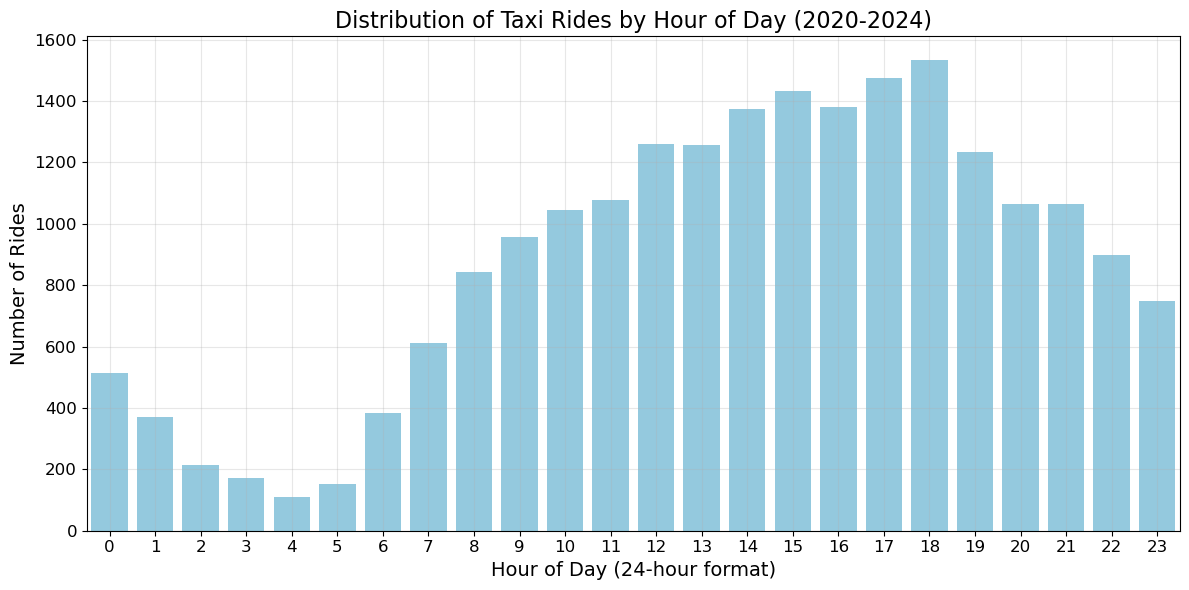

In [90]:
plot_hourly_distribution()

### Visualization 2

In [91]:
def get_data_for_visual_2():
    """
    Query the database to fetch the data for Visualization 2.
    Returns:
        pandas.DataFrame: The dataframe containing monthly average distances and confidence intervals.
    """
    query = """
    WITH combined_trips AS (
        SELECT 
            strftime('%m', tpep_pickup_datetime) AS month,
            trip_distance AS distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT 
        month,
        AVG(distance) AS avg_distance,
        COUNT(*) AS count,
        SUM((distance - (SELECT AVG(distance) 
                         FROM combined_trips t2 
                         WHERE t2.month = t1.month)) *
            (distance - (SELECT AVG(distance) 
                         FROM combined_trips t2 
                         WHERE t2.month = t1.month))) AS sum_squared_diff
    FROM combined_trips t1
    GROUP BY month
    ORDER BY month;
    """
    # Execute query and fetch results into a DataFrame
    return pd.read_sql(query, engine)



In [92]:
def plot_visual_2(dataframe):
    """
    Plot Visualization 2: Average Trip Distance per Month with 90% Confidence Interval.
    Args:
        dataframe (pandas.DataFrame): The dataframe containing the required data.
    """
    # Prepare data for plotting
    confidence_level = 0.90
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    dataframe['std_dev'] = np.sqrt(dataframe['sum_squared_diff'] / (dataframe['count'] - 1))
    dataframe['margin_of_error'] = z_score * (dataframe['std_dev'] / np.sqrt(dataframe['count']))
    dataframe['month'] = dataframe['month'].astype(int)

    # Create the plot
    figure, axes = plt.subplots(figsize=(20, 10))
    axes.plot(dataframe['month'], dataframe['avg_distance'], label="Average Distance", color='blue')
    axes.fill_between(
        dataframe['month'],
        dataframe['avg_distance'] - dataframe['margin_of_error'],
        dataframe['avg_distance'] + dataframe['margin_of_error'],
        color='blue',
        alpha=0.2,
        label="90% Confidence Interval"
    )

    # Customize the plot
    axes.set_title("Average Trip Distance by Month (2020-2024)", fontsize=18)
    axes.set_xlabel("Month", fontsize=14)
    axes.set_ylabel("Average Distance (miles)", fontsize=14)
    axes.set_xticks(range(1, 13))
    axes.set_xticklabels(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        fontsize=12
    )
    axes.legend(fontsize=12)
    axes.grid(alpha=0.3)

    # Show the plot
    plt.tight_layout()
    plt.show()

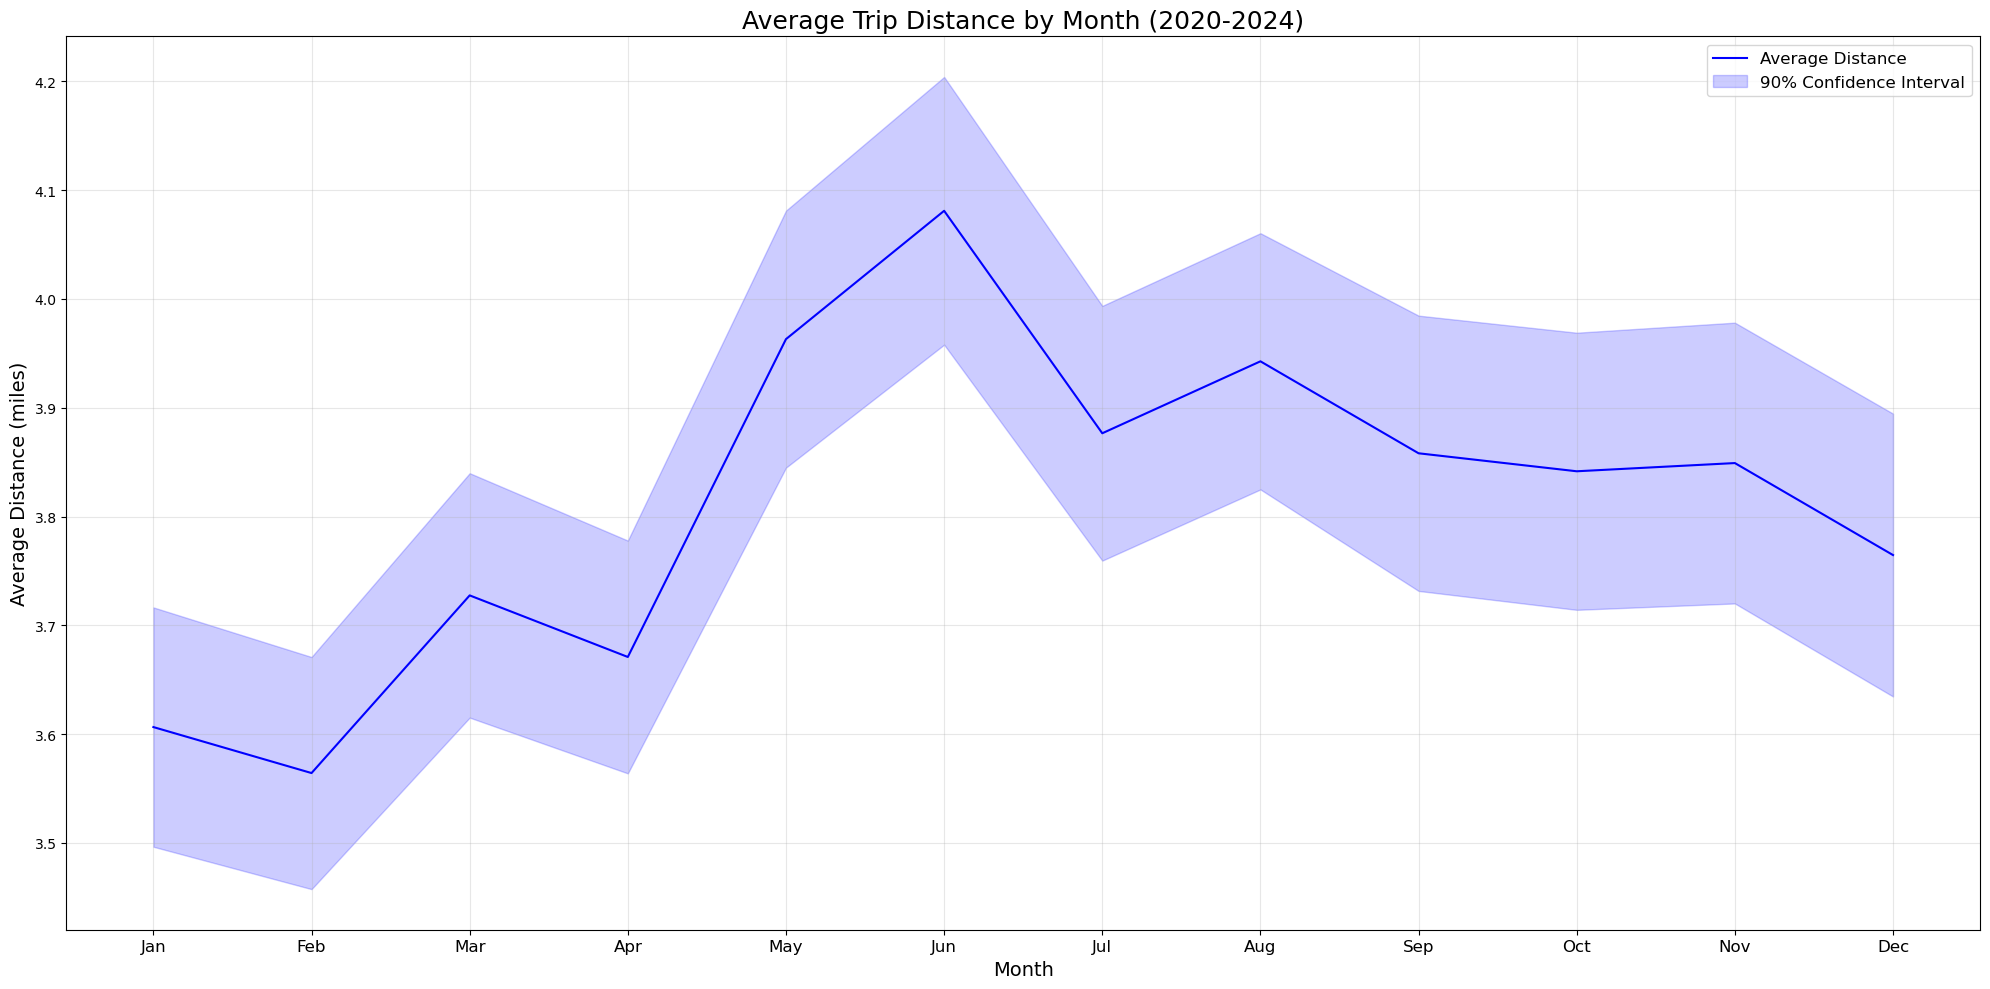

In [105]:
visual_2_dataframe = get_data_for_visual_2()
plot_visual_2(visual_2_dataframe)

### Visualization 3

In [141]:
def plot_airport_dropoffs():
    # Define airport bounding boxes
    airports_query = """
    WITH combined_trips AS (
        SELECT
            'Taxi' as service_type,
            tpep_dropoff_datetime as dropoff_time,
            dropoff_latitude as lat,
            dropoff_longitude as lon
        FROM taxi_trips
        WHERE tpep_dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT
            'Uber' as service_type,
            pickup_datetime as dropoff_time,
            dropoff_latitude as lat,
            dropoff_longitude as lon
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT
        CASE
            WHEN lat BETWEEN 40.763589 AND 40.778865
            AND lon BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
            WHEN lat BETWEEN 40.639263 AND 40.651376
            AND lon BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
            WHEN lat BETWEEN 40.686794 AND 40.699680
            AND lon BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
        END as airport,
        strftime('%w', dropoff_time) as day_of_week,
        COUNT(*) as dropoff_count
    FROM combined_trips
    WHERE
        (lat BETWEEN 40.763589 AND 40.778865 AND lon BETWEEN -73.891745 AND -73.854838) OR
        (lat BETWEEN 40.639263 AND 40.651376 AND lon BETWEEN -73.795642 AND -73.766264) OR
        (lat BETWEEN 40.686794 AND 40.699680 AND lon BETWEEN -74.194028 AND -74.165205)
    GROUP BY airport, day_of_week
    ORDER BY airport, day_of_week;
    """

    airport_data = pd.read_sql(airports_query, engine)
    airport_data['day_name'] = airport_data['day_of_week'].map({
        '0': 'Sun', '1': 'Mon', '2': 'Tue', '3': 'Wed',
        '4': 'Thu', '5': 'Fri', '6': 'Sat'
    })

    plt.figure(figsize=(12, 6))
    airports = ['JFK', 'LGA', 'EWR']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for airport, color in zip(airports, colors):
        airport_subset = airport_data[airport_data['airport'] == airport]
        if not airport_subset.empty:
            plt.plot(airport_subset['day_name'],
                    airport_subset['dropoff_count'],
                    'o-',
                    label=airport,
                    color=color)

    plt.title('Airport Dropoffs by Day of Week (2020-2024)')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Dropoffs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



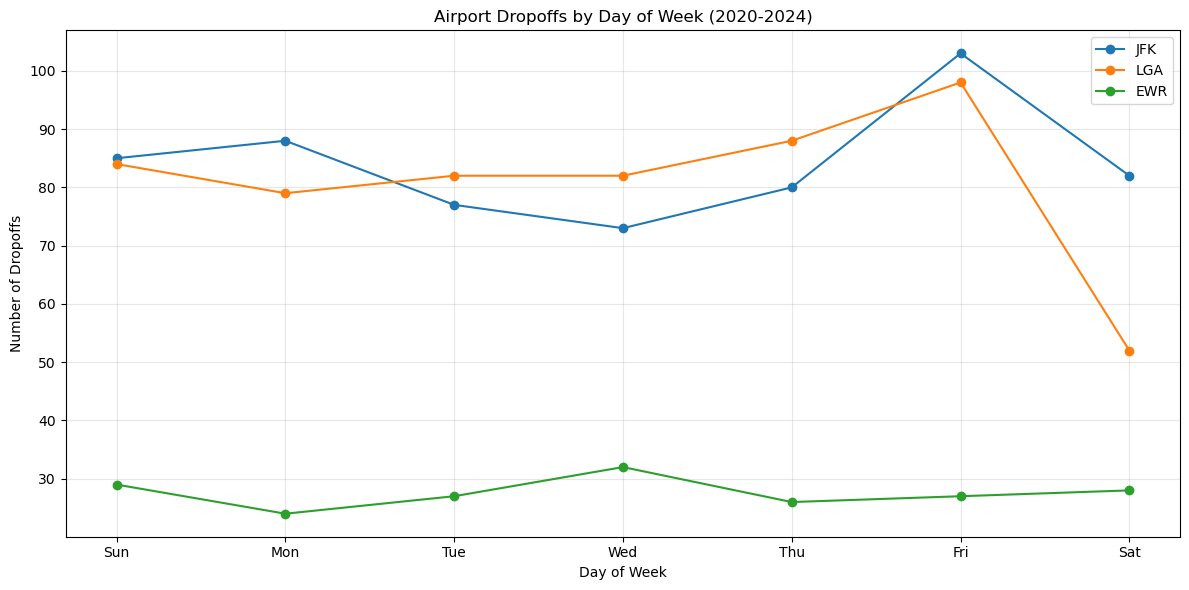

In [143]:
plot_airport_dropoffs()

### Visualization 4

In [108]:
def get_monthly_fares():
    """
    Query to get monthly fare breakdowns for both taxi and uber rides
    """
    taxi_query = """
    SELECT 
        strftime('%Y-%m', tpep_pickup_datetime) as month,
        SUM(fare_amount) as base_fare,
        SUM(mta_tax) as tax,
        SUM(improvement_surcharge + congestion_surcharge) as surcharges,
        0 as tolls,
        'Yellow Taxi' as service_type
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month
    """
    
    uber_query = """
    SELECT 
        strftime('%Y-%m', pickup_datetime) as month,
        SUM(base_passenger_fare) as base_fare,
        SUM(sales_tax) as tax,
        SUM(congestion_surcharge) as surcharges,
        SUM(tolls) as tolls,
        'Uber' as service_type
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month
    """
    
    taxi_data = pd.read_sql(taxi_query, engine)
    uber_data = pd.read_sql(uber_query, engine)
    
    return pd.concat([taxi_data, uber_data])

def plot_monthly_fares(fare_data):
    """
    Create stacked bar chart for monthly fares
    """
    plt.figure(figsize=(15, 8))
    
    # Prepare data for plotting
    taxi_data = fare_data[fare_data['service_type'] == 'Yellow Taxi'].copy()
    uber_data = fare_data[fare_data['service_type'] == 'Uber'].copy()
    
    width = 0.35
    x = np.arange(len(taxi_data))
    
    # Plot Yellow Taxi bars
    plt.bar(x - width/2, taxi_data['base_fare'], width, label='Taxi Base Fare')
    plt.bar(x - width/2, taxi_data['tax'], width, bottom=taxi_data['base_fare'], label='Taxi Tax')
    plt.bar(x - width/2, taxi_data['surcharges'], width, 
            bottom=taxi_data['base_fare'] + taxi_data['tax'], label='Taxi Surcharges')
    
    # Plot Uber bars
    plt.bar(x + width/2, uber_data['base_fare'], width, label='Uber Base Fare')
    plt.bar(x + width/2, uber_data['tax'], width, bottom=uber_data['base_fare'], label='Uber Tax')
    plt.bar(x + width/2, uber_data['surcharges'], width, 
            bottom=uber_data['base_fare'] + uber_data['tax'], label='Uber Surcharges')
    plt.bar(x + width/2, uber_data['tolls'], width,
            bottom=uber_data['base_fare'] + uber_data['tax'] + uber_data['surcharges'], 
            label='Uber Tolls')
    
    plt.xlabel('Month')
    plt.ylabel('Total Fares ($)')
    plt.title('Monthly Fare Breakdown: Yellow Taxi vs Uber (2020-2024)')
    plt.xticks(x, taxi_data['month'], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

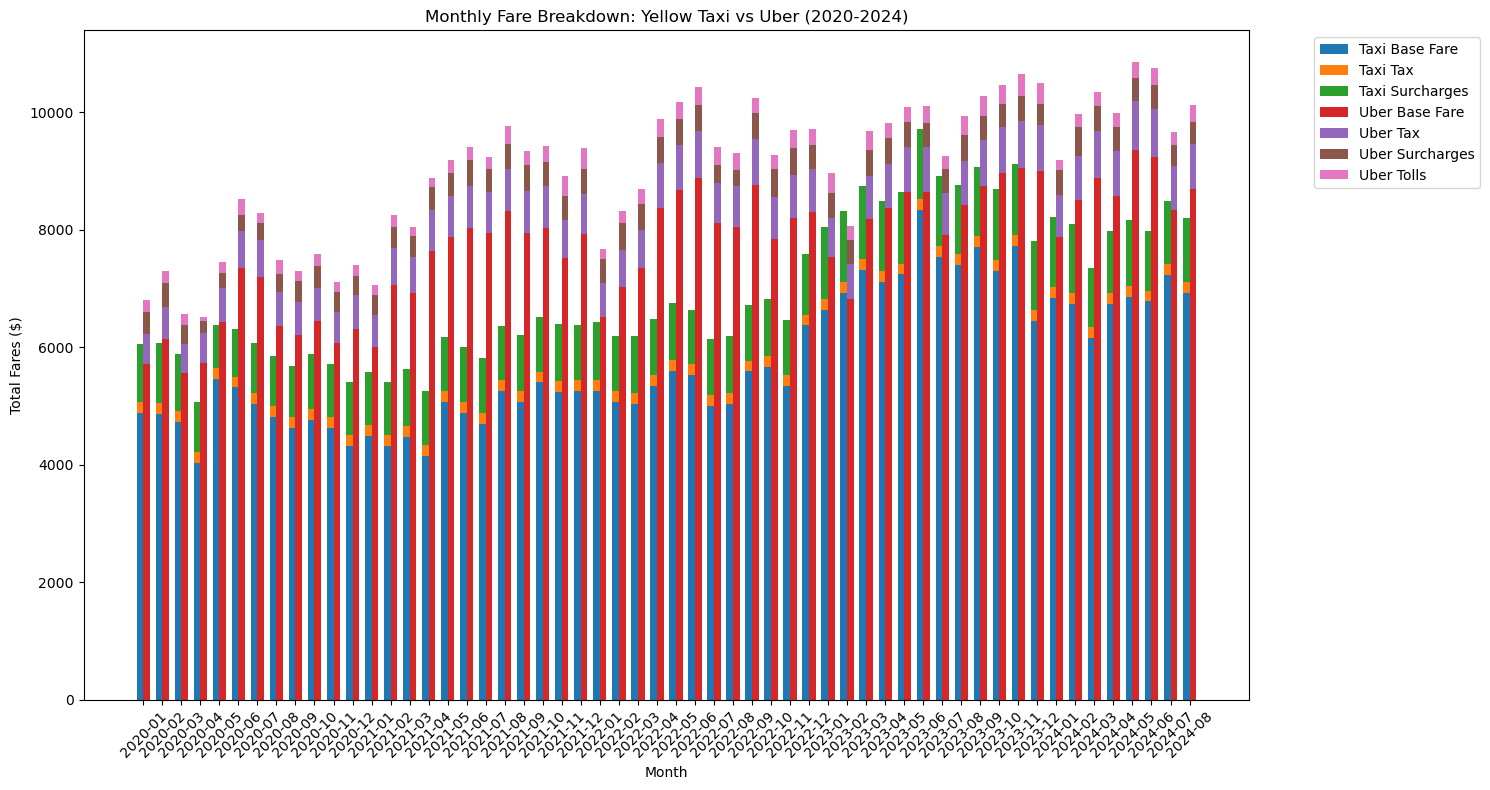

<Figure size 640x480 with 0 Axes>

In [110]:
monthly_fares = get_monthly_fares()
plot_monthly_fares(monthly_fares)
plt.figure()

### Visualization 5

In [112]:
def get_tip_data():
    """
    Query to get tip data with weather and distance information with additional filtering
    """
    taxi_query = """
    SELECT 
        t.trip_distance as distance,
        (t.total_amount - t.fare_amount - t.mta_tax - 
         t.improvement_surcharge - COALESCE(t.congestion_surcharge, 0)) as tip,
        COALESCE(w.Precipitation, 0) as precipitation,
        'Yellow Taxi' as service_type
    FROM taxi_trips t
    LEFT JOIN hourly_weather w 
        ON strftime('%Y-%m-%d %H', t.tpep_pickup_datetime) = strftime('%Y-%m-%d %H', w.date)
    WHERE t.tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
        AND t.trip_distance > 0 
        AND t.total_amount > t.fare_amount
        AND t.total_amount < 1000
    """
    
    uber_query = """
    SELECT 
        u.trip_miles as distance,
        (u.base_passenger_fare * 0.2) as tip,
        COALESCE(w.Precipitation, 0) as precipitation,
        'Uber' as service_type
    FROM uber_trips u
    LEFT JOIN hourly_weather w 
        ON strftime('%Y-%m-%d %H', u.pickup_datetime) = strftime('%Y-%m-%d %H', w.date)
    WHERE u.pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
        AND u.trip_miles > 0 
        AND u.base_passenger_fare > 0
        AND u.base_passenger_fare < 1000
    """
    
    taxi_data = pd.read_sql(taxi_query, engine)
    uber_data = pd.read_sql(uber_query, engine)
    
    return pd.concat([taxi_data, uber_data])

def plot_tip_relationships(tip_data):
    """
    Create 2x2 scatter plots for tip analysis with robust handling of data
    """
    def remove_outliers(df, columns):
        df_clean = df.copy()
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = ~((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR)))
            df_clean = df_clean[mask]
        return df_clean
    
    def safe_scatter_plot(ax, x_data, y_data, title, xlabel, ylabel):
        # Remove any NaN values
        mask = ~(np.isnan(x_data) | np.isnan(y_data))
        x_clean = x_data[mask]
        y_clean = y_data[mask]
        
        if len(x_clean) == 0 or len(y_clean) == 0:
            print(f"No valid data points for {title}")
            return
        
        # Create scatter plot
        ax.scatter(x_clean, y_clean, alpha=0.3, s=50, color='blue')
        
        # Only add trend line if we have enough valid data points
        if len(x_clean) > 2:
            try:
                # Calculate trend line
                z = np.polyfit(x_clean, y_clean, 1)
                p = np.poly1d(z)
                
                # Create points for trend line
                x_range = np.linspace(x_clean.min(), x_clean.max(), 100)
                ax.plot(x_range, p(x_range), "r--", alpha=0.8)
                
                # Add correlation coefficient
                correlation = np.corrcoef(x_clean, y_clean)[0, 1]
                ax.text(0.05, 0.95, f'r = {correlation:.2f}', 
                       transform=ax.transAxes, fontsize=10)
            except Exception as e:
                print(f"Could not calculate trend line for {title}: {str(e)}")
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    # Split and clean data
    taxi_data = remove_outliers(
        tip_data[tip_data['service_type'] == 'Yellow Taxi'],
        ['tip', 'distance', 'precipitation']
    )
    uber_data = remove_outliers(
        tip_data[tip_data['service_type'] == 'Uber'],
        ['tip', 'distance', 'precipitation']
    )
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Define the plots
    plots = [
        {
            'ax': axes[0,0],
            'x_data': taxi_data['distance'],
            'y_data': taxi_data['tip'],
            'title': 'Yellow Taxi: Distance vs Tip',
            'xlabel': 'Distance (miles)',
            'ylabel': 'Tip Amount ($)'
        },
        {
            'ax': axes[0,1],
            'x_data': uber_data['distance'],
            'y_data': uber_data['tip'],
            'title': 'Uber: Distance vs Tip',
            'xlabel': 'Distance (miles)',
            'ylabel': 'Tip Amount ($)'
        },
        {
            'ax': axes[1,0],
            'x_data': taxi_data['precipitation'],
            'y_data': taxi_data['tip'],
            'title': 'Yellow Taxi: Precipitation vs Tip',
            'xlabel': 'Precipitation (inches)',
            'ylabel': 'Tip Amount ($)'
        },
        {
            'ax': axes[1,1],
            'x_data': uber_data['precipitation'],
            'y_data': uber_data['tip'],
            'title': 'Uber: Precipitation vs Tip',
            'xlabel': 'Precipitation (inches)',
            'ylabel': 'Tip Amount ($)'
        }
    ]
    
    # Create all plots
    for plot in plots:
        safe_scatter_plot(
            plot['ax'],
            plot['x_data'],
            plot['y_data'],
            plot['title'],
            plot['xlabel'],
            plot['ylabel']
        )
    
    plt.tight_layout()
    return fig

D:\anaconda\Lib\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


Could not calculate trend line for Yellow Taxi: Precipitation vs Tip: SVD did not converge in Linear Least Squares
Could not calculate trend line for Uber: Precipitation vs Tip: SVD did not converge in Linear Least Squares


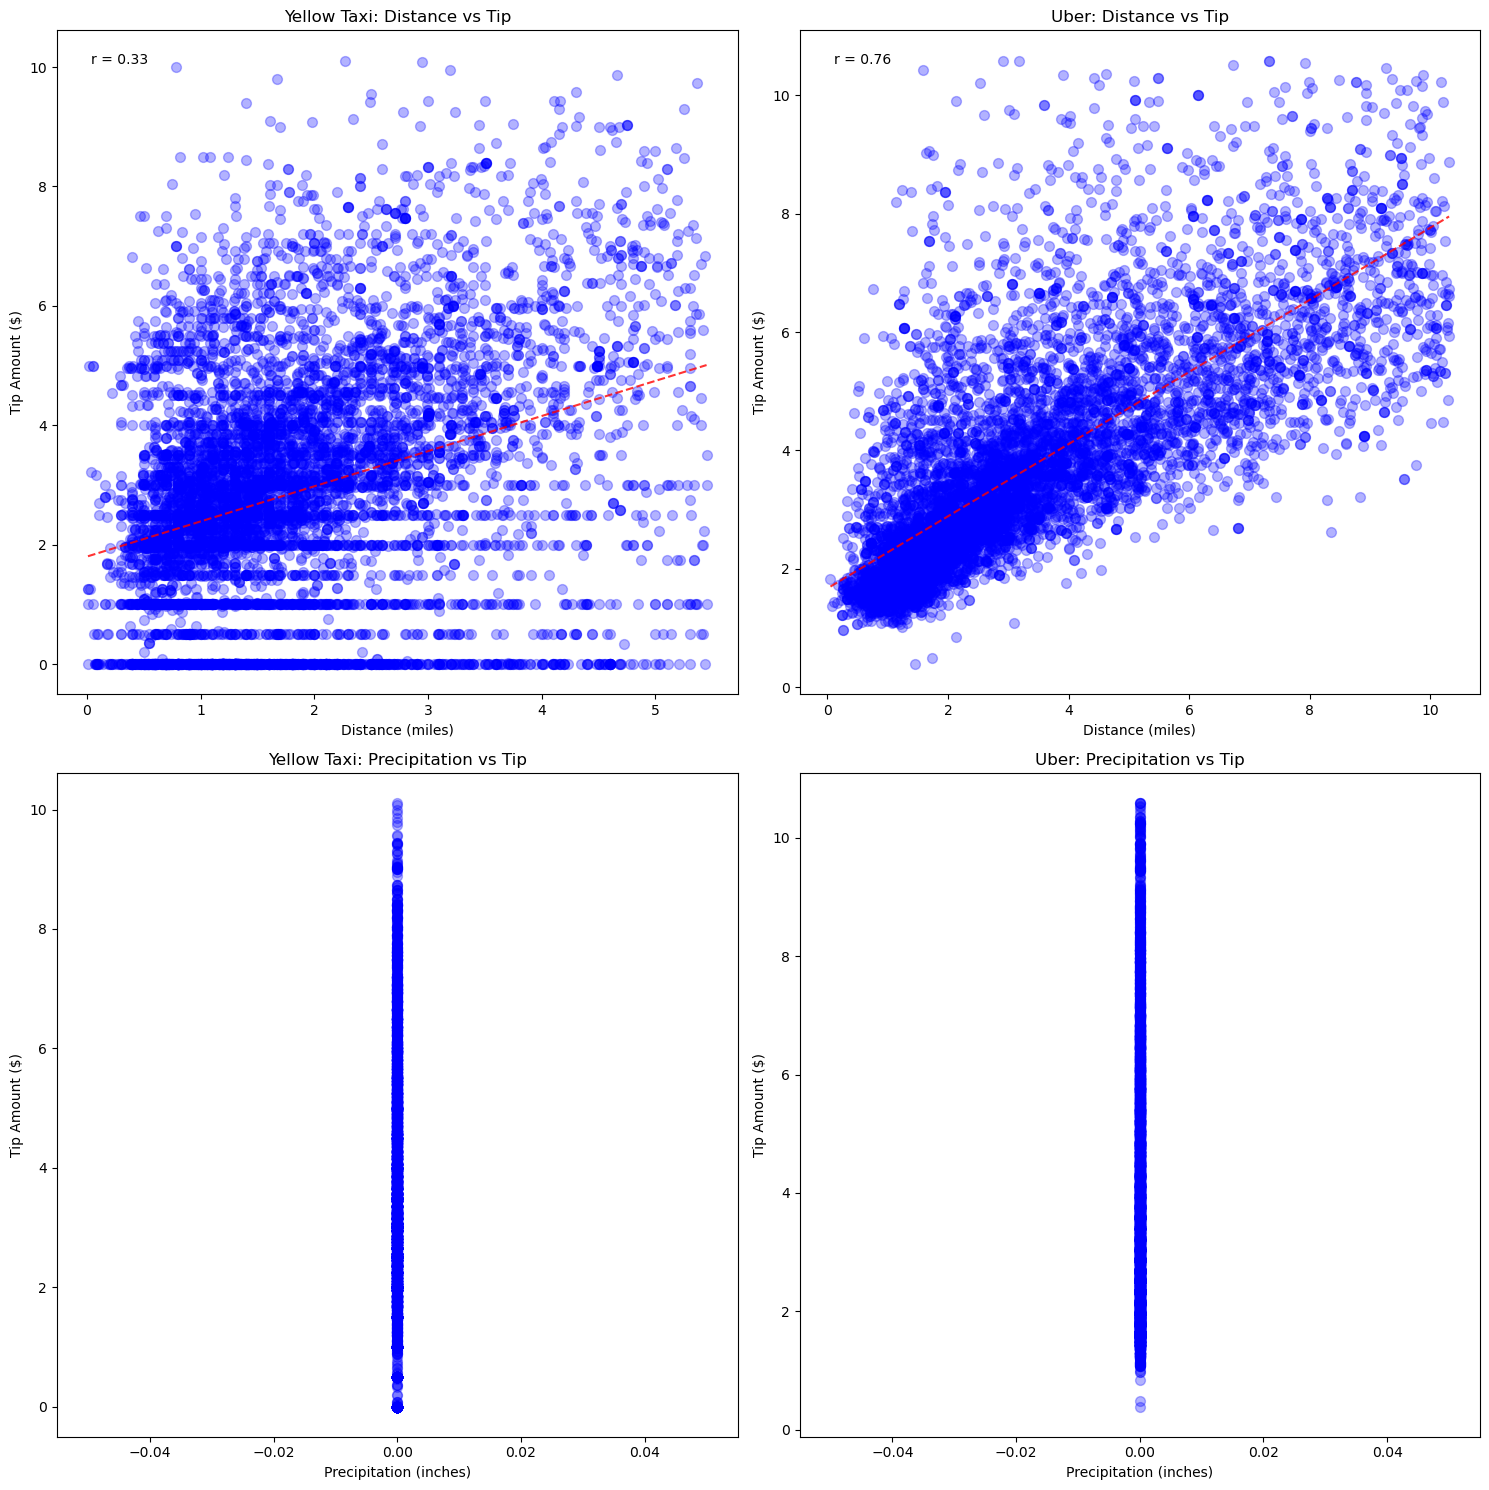

In [114]:
tip_data = get_tip_data()
fig = plot_tip_relationships(tip_data)
plt.show()

### Visualization 6

In [165]:
def create_trips_heatmap_matplotlib(engine):
    """
    Creates a static heatmap of all hired trips (taxi and uber) in 2020 over NYC area

    Args:
        engine: SQLAlchemy database engine
    """
    query = """
    WITH all_pickups AS (
        SELECT
            pickup_latitude as lat,
            pickup_longitude as lon
        FROM taxi_trips
        WHERE strftime('%Y', tpep_pickup_datetime) = '2020'

        UNION ALL

        SELECT
            pickup_latitude as lat,
            pickup_longitude as lon
        FROM uber_trips
        WHERE strftime('%Y', pickup_datetime) = '2020'
    )
    SELECT lat, lon
    FROM all_pickups
    WHERE lat IS NOT NULL AND lon IS NOT NULL;
    """

    pickup_locations = pd.read_sql(query, engine)

    # Figure size
    plt.figure(figsize=(10, 8))
    
    # Create a 2D histogram for the density heatmap
    sns.kdeplot(
        data=pickup_locations,
        x='lon', 
        y='lat', 
        fill=True, 
        cmap='coolwarm', 
        levels=100, 
        thresh=0.01
    )
    
    # Add labels and title
    plt.title("NYC Ride-Hailing Pickups Heatmap (2020)", fontsize=16)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(alpha=0.3)

    plt.show()

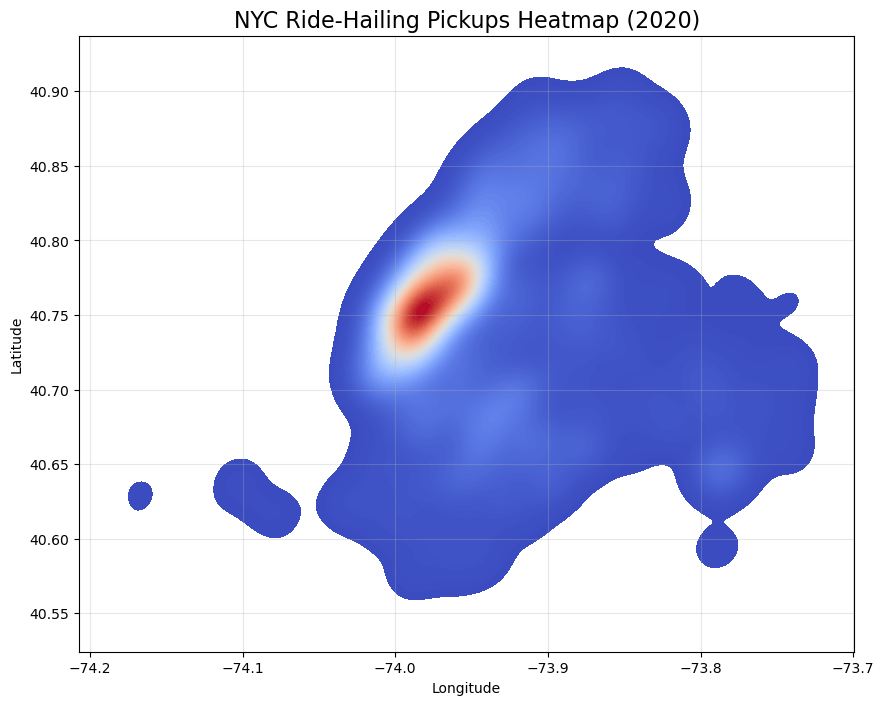

In [163]:
create_trips_heatmap_matplotlib(engine)